In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conn = sqlite3.connect("../db/baltasar.db")
def sql(query):
    return pd.read_sql_query(query, conn)

## Iteration 1

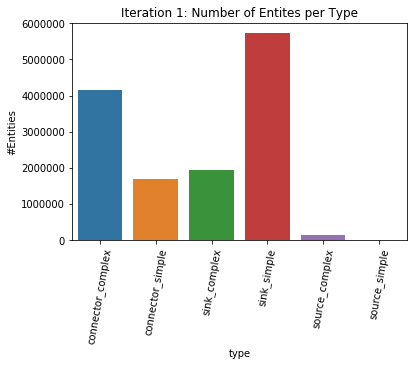

In [9]:
graphProperties = sql('''
SELECT "sink_simple" as type, count(*) as "#Entities" FROM EntityMetadata WHERE indegree = 1 and outdegree = 0
UNION
SELECT "sink_complex", count(*) FROM EntityMetadata WHERE indegree > 1 and outdegree = 0
UNION
SELECT "source_simple", count(*) FROM EntityMetadata WHERE indegree = 0 and outdegree = 1
UNION
SELECT "source_complex", count(*) FROM EntityMetadata WHERE indegree = 0 and outdegree > 1
UNION
SELECT "connector_simple", count(*) FROM EntityMetadata 
WHERE 
    indegree = 1 and outdegree = 1
UNION
SELECT "connector_complex", count(*) FROM EntityMetadata 
WHERE 
    indegree > 0 and outdegree > 0
''')
ax = sns.barplot(data=graphProperties, x='type', y='#Entities')
ax.set_title('Iteration 1: Number of Entites per Type')
plt.xticks(rotation=80)
plt.savefig('graphs/iter1.pdf')
plt.show()

In [11]:
graphProperties

,type,#Entities
0,connector_complex,4160266
1,connector_simple,1681459
2,sink_complex,1943297
3,sink_simple,5726386
4,source_complex,158433
5,source_simple,13005


## Iteration 2

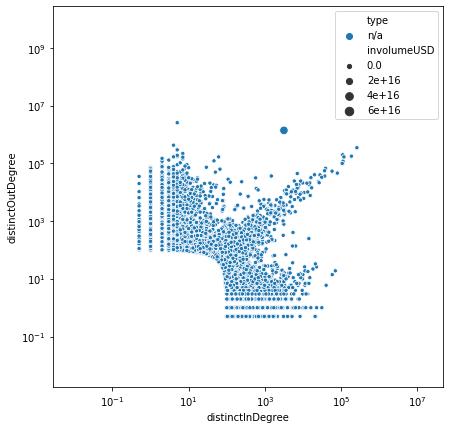

In [17]:
df = sql('SELECT * FROM EntityMetadata WHERE distinctDegree >= 100')

df['type'] = "n/a"
df.loc[df['distinctInDegree'] == 0, ['distinctInDegree']] = 0.5
df.loc[df['distinctOutDegree'] == 0, 'distinctOutDegree'] = 0.5

#df.loc[df['isDiluter'] == 1, ['type']] = 'diluter'
#df.loc[df['isMixer'] == 1, ['type']] = 'mixer'
#df.loc[df['isConcentrator'] == 1, ['type']] = 'concentrator'

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x='distinctInDegree', y='distinctOutDegree', hue="type", size="involumeUSD", data=df, ax=ax)

# Iteration 3

In [ ]:
df = sql('''
SELECT lastActiveOn / 1000 as blockGrouped, count(*)
    FROM
    (SELECT name, MAX(l_in, l_out) as lastActiveOn FROM 
        EntityMetadata m
        INNER JOIN
        (SELECT `to` as name_in, MAX(blocknumber) as l_in FROM ETransfer group by `to`)
        LEFT OUTER JOIN
        (SELECT `to` as name_out, MAX(blocknumber) as l_out FROM ETransfer group by `from`)
        ON name_in = name_out and name_in = m.name
    WHERE
        not involumeUSD - outvolumeUSD BETWEEN -0.05 and 0.05)
GROUP BY lastActiveOn
''')
df